# 데이터 소개

* 출처: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data 

# 신용카드 고객 이탈 예측 - EDA (Exploratory Data Analysis)

이 노트북은 신용카드 고객 이탈(Churn) 예측을 위한 기본적인 탐색적 데이터 분석을 수행합니다.

## 목차
1. 데이터 로드 및 기본 정보 확인
2. 데이터 품질 체크 (결측치, 이상치)
3. Target 변수 분석 (Attrition_Flag)
4. 수치형 변수 분석
5. 범주형 변수 분석
6. 상관관계 분석
7. Feature Engineering 아이디어
8. 주요 인사이트 정리

## 1. 데이터 로드 및 기본 정보 확인

In [4]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 설정
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 출력 옵션
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [5]:
# 데이터 로드 (파일 경로를 실제 경로로 변경하세요)
df = pd.read_csv('../../data/raw/BankChurners.csv')

print("데이터 shape:", df.shape)
print(f"\n총 {df.shape[0]:,}개의 행, {df.shape[1]}개의 컬럼")

데이터 shape: (10127, 23)

총 10,127개의 행, 23개의 컬럼


In [6]:
# 처음 5개 행 확인
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061,0.000,1.000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105,0.000,1.000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000,0.000,1.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760,0.000,1.000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000,0.000,1.000


In [7]:
print("전체 컬럼 목록:")
columns_info = ["", "회원 ID", "이탈 여부", 
                "나이", "성별", "부양 가족 수", "학력", "결혼 여부", # Demographics
                "소득 구간", "카드 등급", "고객 관계 기간", "총 상품 수", # Card Category
                "12개월 중 비활성화 개월 수", "12개월 중 Contact 횟수", 
                "신용한도", "총 리볼빙 금액", "평균 사용가능 금액", # Credit Info
                "거래금액 변화율", "총 거래량", "총 거래 횟수", "거래 횟수 변화율", "평균 신용 사용률" ,# Transaction Info                "예측 모델 1" , "예측 모델 2"]
                "예측 모델 1" , "예측 모델 2"
                ]

for i, col in enumerate(df.columns, 1):
    info = columns_info[i] if i < len(columns_info) else ""
    print(f"{i:2d}. {col} / {info}")

전체 컬럼 목록:
 1. CLIENTNUM / 회원 ID
 2. Attrition_Flag / 이탈 여부
 3. Customer_Age / 나이
 4. Gender / 성별
 5. Dependent_count / 부양 가족 수
 6. Education_Level / 학력
 7. Marital_Status / 결혼 여부
 8. Income_Category / 소득 구간
 9. Card_Category / 카드 등급
10. Months_on_book / 고객 관계 기간
11. Total_Relationship_Count / 총 상품 수
12. Months_Inactive_12_mon / 12개월 중 비활성화 개월 수
13. Contacts_Count_12_mon / 12개월 중 Contact 횟수
14. Credit_Limit / 신용한도
15. Total_Revolving_Bal / 총 리볼빙 금액
16. Avg_Open_To_Buy / 평균 사용가능 금액
17. Total_Amt_Chng_Q4_Q1 / 거래금액 변화율
18. Total_Trans_Amt / 총 거래량
19. Total_Trans_Ct / 총 거래 횟수
20. Total_Ct_Chng_Q4_Q1 / 거래 횟수 변화율
21. Avg_Utilization_Ratio / 평균 신용 사용률
22. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 / 예측 모델 1
23. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2 / 예측 모델 2


In [8]:
# 데이터 타입 및 기본 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [9]:
print("전체 컬럼 목록:")
columns_info = ["", "회원 ID", "이탈 여부", 
                "나이", "성별", "부양 가족 수", "학력", "결혼 여부", # Demographics
                "소득 구간", "카드 등급", "고객 관계 기간", "총 상품 수", # Card Category
                "12개월 중 비활성화 개월 수", "12개월 중 Contact 횟수", 
                "신용한도", "총 리볼빙 금액", "평균 사용가능 금액", # Credit Info
                "거래금액 변화율", "총 거래량", "총 거래 횟수", "거래 횟수 변화율", "평균 신용 사용률" ,# Transaction Info                "예측 모델 1" , "예측 모델 2"]
                "예측 모델 1" , "예측 모델 2"
                ]

for i, col in enumerate(df.columns, 1):
    info = columns_info[i] if i < len(columns_info) else ""
    print(f"{i:2d}. {col} / {info}")


전체 컬럼 목록:
 1. CLIENTNUM / 회원 ID
 2. Attrition_Flag / 이탈 여부
 3. Customer_Age / 나이
 4. Gender / 성별
 5. Dependent_count / 부양 가족 수
 6. Education_Level / 학력
 7. Marital_Status / 결혼 여부
 8. Income_Category / 소득 구간
 9. Card_Category / 카드 등급
10. Months_on_book / 고객 관계 기간
11. Total_Relationship_Count / 총 상품 수
12. Months_Inactive_12_mon / 12개월 중 비활성화 개월 수
13. Contacts_Count_12_mon / 12개월 중 Contact 횟수
14. Credit_Limit / 신용한도
15. Total_Revolving_Bal / 총 리볼빙 금액
16. Avg_Open_To_Buy / 평균 사용가능 금액
17. Total_Amt_Chng_Q4_Q1 / 거래금액 변화율
18. Total_Trans_Amt / 총 거래량
19. Total_Trans_Ct / 총 거래 횟수
20. Total_Ct_Chng_Q4_Q1 / 거래 횟수 변화율
21. Avg_Utilization_Ratio / 평균 신용 사용률
22. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 / 예측 모델 1
23. Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2 / 예측 모델 2


In [10]:
# 기본 통계량
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000,10127.000
mean,739177606.334,46.326,2.346,35.928,3.813,2.341,2.455,8631.954,1162.814,7469.140,0.760,4404.086,64.859,0.712,0.275,0.160,0.840
std,36903783.450,8.017,1.299,7.986,1.554,1.011,1.106,9088.777,814.987,9090.685,0.219,3397.129,23.473,0.238,0.276,0.365,0.365
min,708082083.000,26.000,0.000,13.000,1.000,0.000,0.000,1438.300,0.000,3.000,0.000,510.000,10.000,0.000,0.000,0.000,0.000
25%,713036770.500,41.000,1.000,31.000,3.000,2.000,2.000,2555.000,359.000,1324.500,0.631,2155.500,45.000,0.582,0.023,0.000,1.000
50%,717926358.000,46.000,2.000,36.000,4.000,2.000,2.000,4549.000,1276.000,3474.000,0.736,3899.000,67.000,0.702,0.176,0.000,1.000
75%,773143533.000,52.000,3.000,40.000,5.000,3.000,3.000,11067.500,1784.000,9859.000,0.859,4741.000,81.000,0.818,0.503,0.000,1.000
max,828343083.000,73.000,5.000,56.000,6.000,6.000,6.000,34516.000,2517.000,34516.000,3.397,18484.000,139.000,3.714,0.999,1.000,1.000


## 2. 데이터 품질 체크

In [11]:
# 'Unknown' 문자열을 결측치로 간주
unknown_values = pd.Series(dtype=int)
for col in df.select_dtypes(include='object').columns:
    unknown_count = (df[col].str.lower() == 'unknown').sum()
    if unknown_count > 0:
        unknown_values[col] = unknown_count

# 결측치 정보
missing_df = pd.DataFrame({
    'Unknown_Count': unknown_values,
    'Missing_Percent': (unknown_values / len(df)) * 100
})
missing_df = missing_df[missing_df['Unknown_Count'] > 0].sort_values('Unknown_Count', ascending=False)

if len(missing_df) > 0:
    print("결측치가 있는 컬럼 ('Unknown' 포함):")
    print(missing_df)
    print(f"\n총 결측치 비율: {(missing_df['Unknown_Count'].sum() / (len(df) * len(df.columns))) * 100:.2f}%")
else:
    print("✓ 결측치가 없습니다!")


결측치가 있는 컬럼 ('Unknown' 포함):
                 Unknown_Count  Missing_Percent
Education_Level           1519           15.000
Income_Category           1112           10.981
Marital_Status             749            7.396

총 결측치 비율: 1.45%


In [12]:
# 중복 행 확인
duplicates = df.duplicated().sum()
print(f"중복 행 개수: {duplicates}")

if duplicates > 0:
    print(f"\n⚠️ 중복 행이 {duplicates}개 있습니다. 확인이 필요합니다.")
else:
    print("✓ 중복 행이 없습니다!")

중복 행 개수: 0
✓ 중복 행이 없습니다!


In [13]:
# CLIENTNUM의 고유값 확인 (고객 ID는 유니크해야 함)
if 'CLIENTNUM' in df.columns:
    unique_clients = df['CLIENTNUM'].nunique()
    total_rows = len(df)
    print(f"총 행 수: {total_rows:,}")
    print(f"고유 고객 수: {unique_clients:,}")
    
    if unique_clients == total_rows:
        print("✓ 모든 CLIENTNUM이 유니크합니다.")
    else:
        print(f"⚠️ 중복된 CLIENTNUM이 있습니다. ({total_rows - unique_clients}개)")

총 행 수: 10,127
고유 고객 수: 10,127
✓ 모든 CLIENTNUM이 유니크합니다.


## 3. Target 변수 분석 (Attrition_Flag)

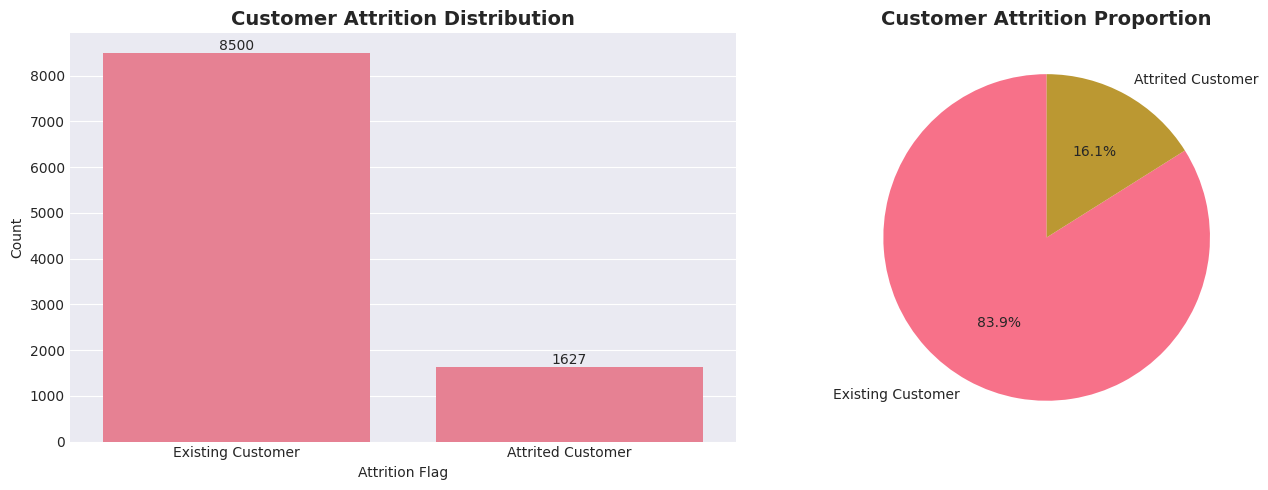


⚠️ 클래스 불균형 발견! (비율: 0.191)
→ SMOTE, class_weight 조정 등의 기법을 고려해야 합니다.


In [14]:
# Target 변수 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Attrition_Flag', ax=axes[0])
axes[0].set_title('Customer Attrition Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attrition Flag')
axes[0].set_ylabel('Count')

# 각 막대 위에 숫자 표시
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
attrition_counts = df['Attrition_Flag'].value_counts()
axes[1].pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Customer Attrition Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 클래스 불균형 체크
minority_class_ratio = attrition_counts.min() / attrition_counts.max()
if minority_class_ratio < 0.3:
    print(f"\n⚠️ 클래스 불균형 발견! (비율: {minority_class_ratio:.3f})")
    print("→ SMOTE, class_weight 조정 등의 기법을 고려해야 합니다.")
else:
    print(f"\n✓ 클래스 불균형이 심하지 않습니다. (비율: {minority_class_ratio:.3f})")

In [15]:
# Target 변수를 이진 변수로 변환 (분석 편의를 위해)
df['Attrition_Binary'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)
print("Attrition_Binary 컬럼 생성 완료 (1: 이탈, 0: 유지)")

Attrition_Binary 컬럼 생성 완료 (1: 이탈, 0: 유지)


## 4. 수치형 변수 분석

In [16]:
# 수치형 변수 리스트 (분석에 사용할 주요 변수들)
numerical_cols = [
    'Customer_Age', # 고객 나이
    'Dependent_count', # 부양 가족 수
    'Months_on_book', # 고객이 은행과 거래한 개월 수
    'Total_Relationship_Count', # 고객과의 관계 수
    'Months_Inactive_12_mon', # 비활성 월 수
    'Contacts_Count_12_mon', # 연락 횟수
    'Credit_Limit', # 신용 한도
    'Total_Revolving_Bal', # 회전 잔액
    'Avg_Open_To_Buy', # 평균 오픈 투 바이
    'Total_Amt_Chng_Q4_Q1', # 금액 변화율
    'Total_Trans_Amt', # 총 거래 금액
    'Total_Trans_Ct', # 총 거래 횟수
    'Total_Ct_Chng_Q4_Q1', # 총 변화율
    'Avg_Utilization_Ratio' # 평균 활용 비율
]

# 실제 데이터에 있는 컬럼만 필터링
numerical_cols = [col for col in numerical_cols if col in df.columns]

print(f"분석할 수치형 변수: {len(numerical_cols)}개")
for col in numerical_cols:
    print(f"  - {col}")

분석할 수치형 변수: 14개
  - Customer_Age
  - Dependent_count
  - Months_on_book
  - Total_Relationship_Count
  - Months_Inactive_12_mon
  - Contacts_Count_12_mon
  - Credit_Limit
  - Total_Revolving_Bal
  - Avg_Open_To_Buy
  - Total_Amt_Chng_Q4_Q1
  - Total_Trans_Amt
  - Total_Trans_Ct
  - Total_Ct_Chng_Q4_Q1
  - Avg_Utilization_Ratio


In [17]:
# 수치형 변수 기본 통계
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.000,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Dependent_count,10127.000,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Months_on_book,10127.000,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,3.813,1.554,1.000,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.000,2.341,1.011,0.000,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.000,2.455,1.106,0.000,2.000,2.000,3.000,6.000
Credit_Limit,10127.000,8631.954,9088.777,1438.300,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.000,1162.814,814.987,0.000,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.000,7469.140,9090.685,3.000,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.000,0.760,0.219,0.000,0.631,0.736,0.859,3.397


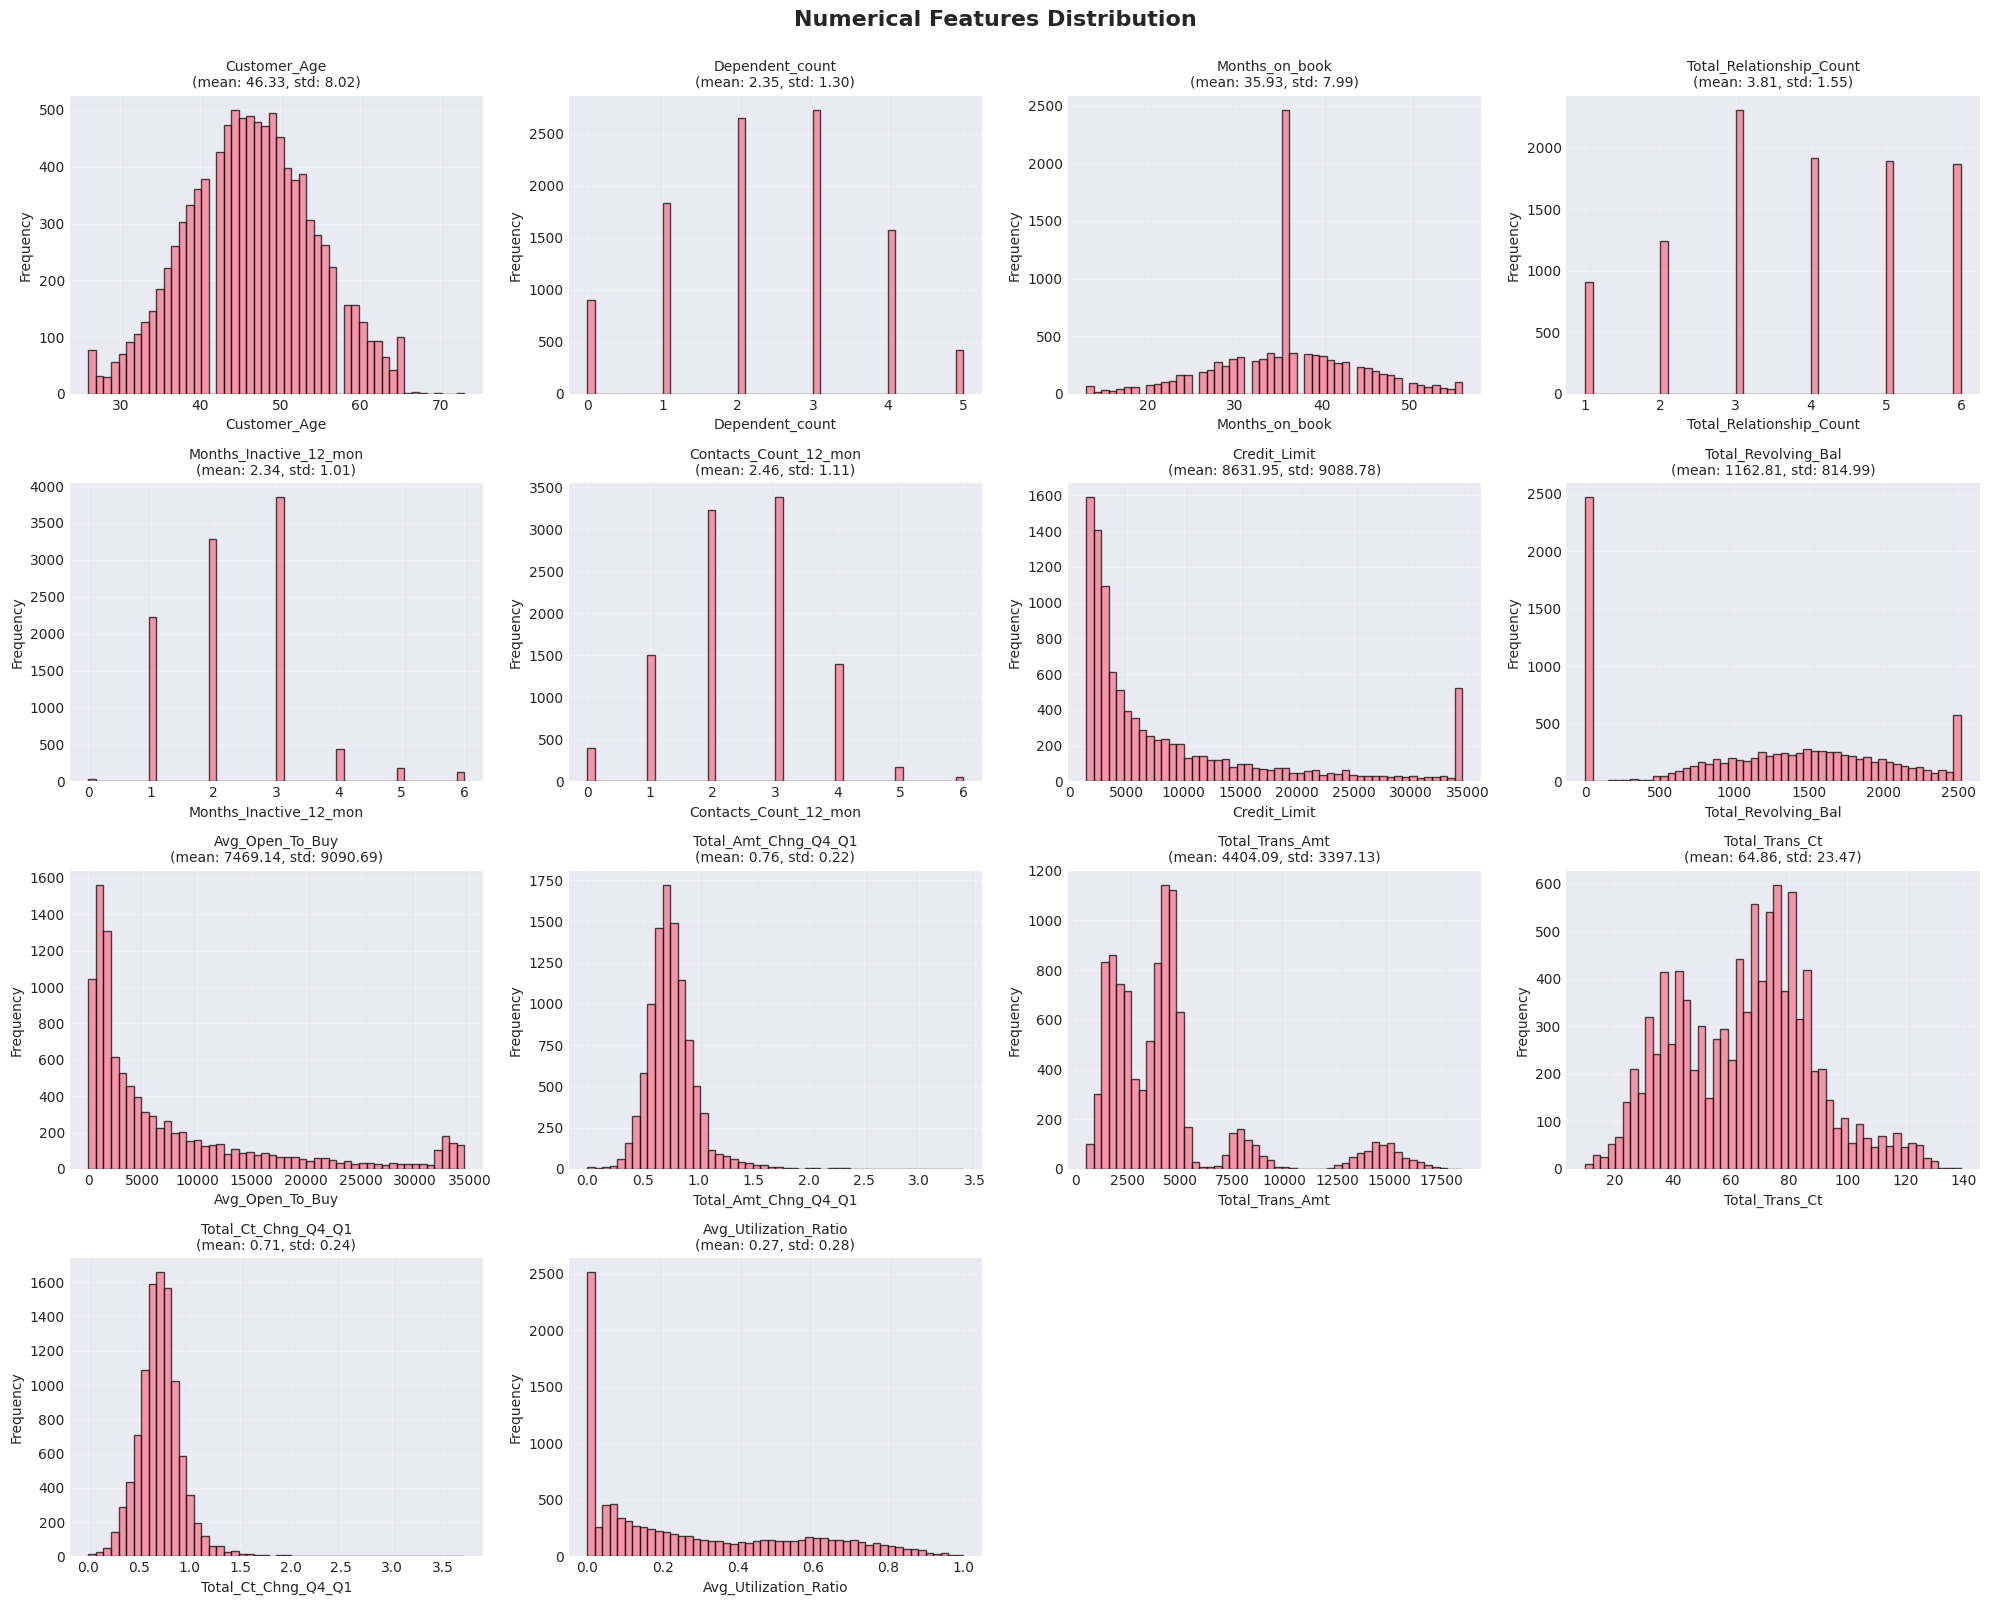

In [18]:
# 수치형 변수 분포 시각화
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}\n(mean: {df[col].mean():.2f}, std: {df[col].std():.2f})', 
                       fontsize=10)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

# 빈 subplot 제거
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Numerical Features Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

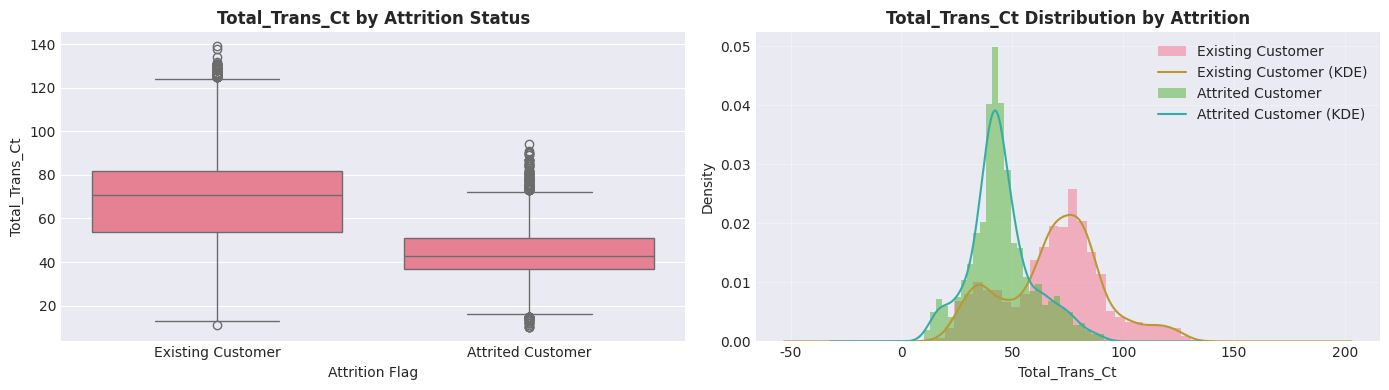


Total_Trans_Ct - 평균값 비교:
Attrition_Flag
Attrited Customer   44.934
Existing Customer   68.673
Name: Total_Trans_Ct, dtype: float64
--------------------------------------------------


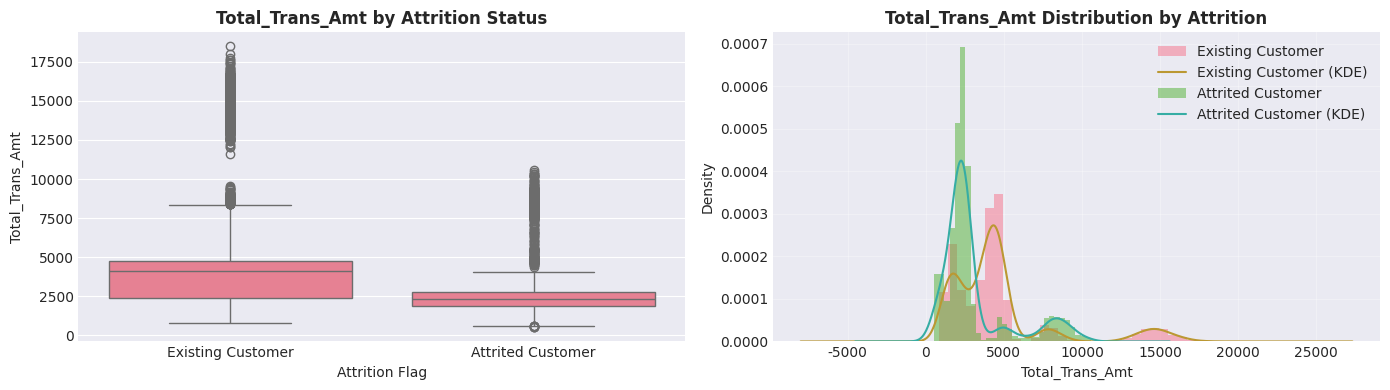


Total_Trans_Amt - 평균값 비교:
Attrition_Flag
Attrited Customer   3095.026
Existing Customer   4654.656
Name: Total_Trans_Amt, dtype: float64
--------------------------------------------------


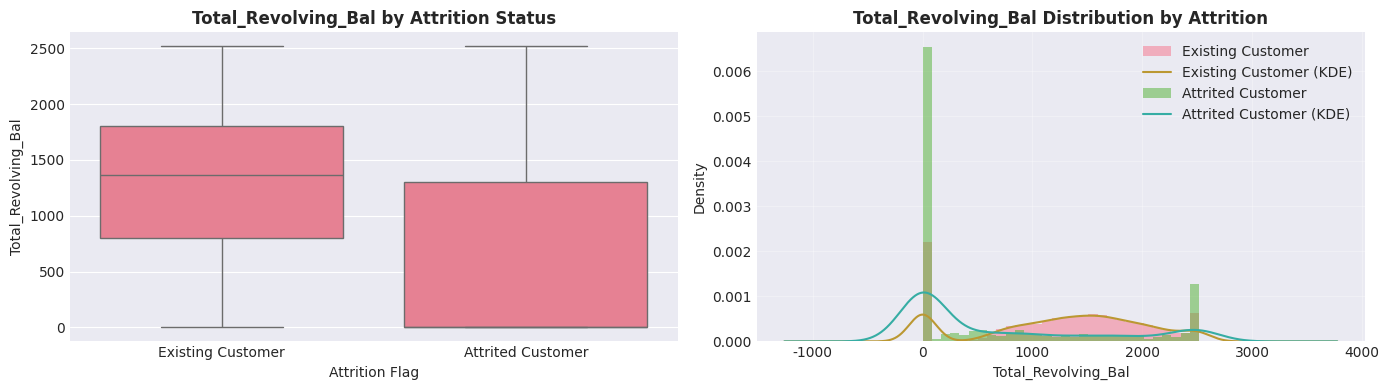


Total_Revolving_Bal - 평균값 비교:
Attrition_Flag
Attrited Customer    672.823
Existing Customer   1256.604
Name: Total_Revolving_Bal, dtype: float64
--------------------------------------------------


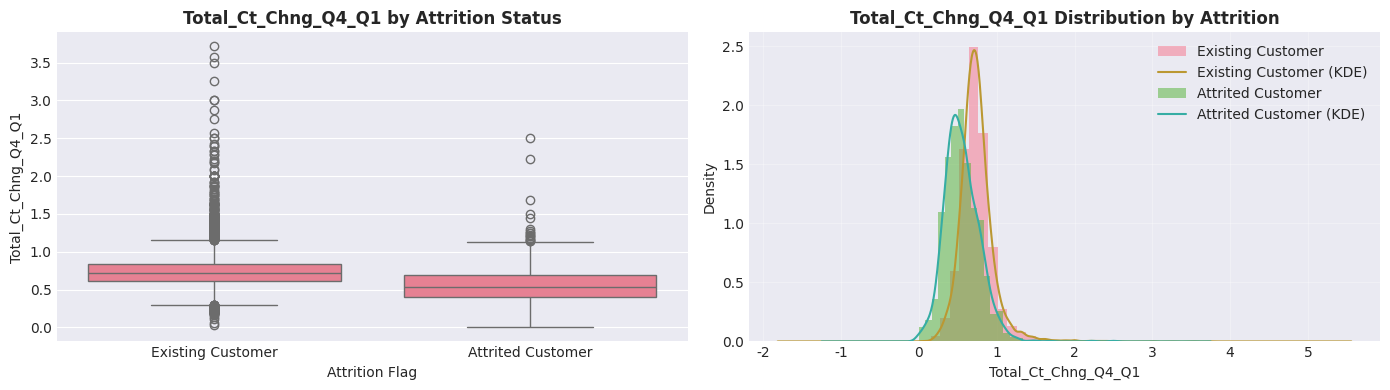


Total_Ct_Chng_Q4_Q1 - 평균값 비교:
Attrition_Flag
Attrited Customer   0.554
Existing Customer   0.742
Name: Total_Ct_Chng_Q4_Q1, dtype: float64
--------------------------------------------------


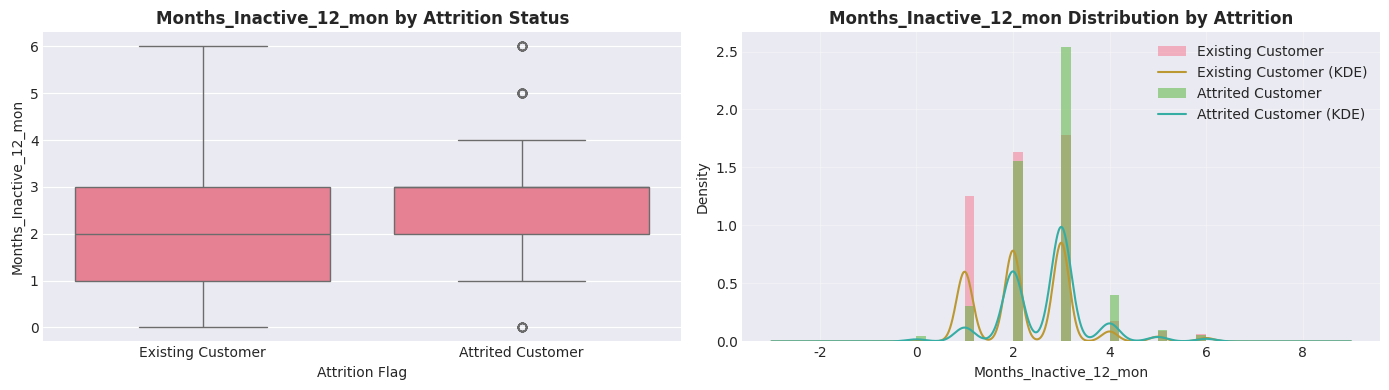


Months_Inactive_12_mon - 평균값 비교:
Attrition_Flag
Attrited Customer   2.693
Existing Customer   2.274
Name: Months_Inactive_12_mon, dtype: float64
--------------------------------------------------


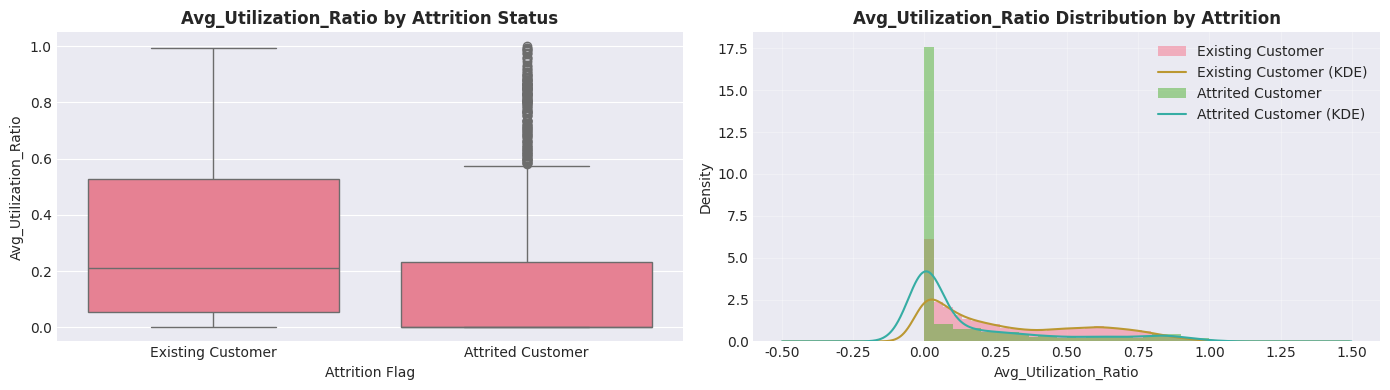


Avg_Utilization_Ratio - 평균값 비교:
Attrition_Flag
Attrited Customer   0.162
Existing Customer   0.296
Name: Avg_Utilization_Ratio, dtype: float64
--------------------------------------------------


In [19]:
# 이탈 여부에 따른 수치형 변수 비교 (중요!)
# 상위 6개 변수만 시각화 (전체는 너무 많으므로)
important_cols = [
    'Total_Trans_Ct',
    'Total_Trans_Amt', 
    'Total_Revolving_Bal',
    'Total_Ct_Chng_Q4_Q1',
    'Months_Inactive_12_mon',
    'Avg_Utilization_Ratio'
]

# 실제 데이터에 있는 컬럼만 필터링
important_cols = [col for col in important_cols if col in df.columns]

for col in important_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Box plot
    sns.boxplot(data=df, x='Attrition_Flag', y=col, ax=axes[0])
    axes[0].set_title(f'{col} by Attrition Status', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Attrition Flag')
    axes[0].set_ylabel(col)
      
    # Distribution plot with KDE
    for flag in df['Attrition_Flag'].unique():
        subset = df[df['Attrition_Flag'] == flag][col].dropna()
        axes[1].hist(subset, bins=30, alpha=0.5, label=flag, density=True)
        subset.plot(kind='kde', ax=axes[1], label=f'{flag} (KDE)')
    
    axes[1].set_title(f'{col} Distribution by Attrition', fontsize=12, fontweight='bold')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 평균값 비교
    mean_by_attrition = df.groupby('Attrition_Flag')[col].mean()
    print(f"\n{col} - 평균값 비교:")
    print(mean_by_attrition)
    print("-" * 50)

## 5. 범주형 변수 분석

In [20]:
# 범주형 변수 리스트
categorical_cols = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'
]

# 실제 데이터에 있는 컬럼만 필터링
categorical_cols = [col for col in categorical_cols if col in df.columns]

print(f"분석할 범주형 변수: {len(categorical_cols)}개")
for col in categorical_cols:
    print(f"  - {col}")

분석할 범주형 변수: 5개
  - Gender
  - Education_Level
  - Marital_Status
  - Income_Category
  - Card_Category


In [21]:
# 범주형 변수별 고유값 개수 확인
print("범주형 변수의 고유값 개수:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"{col}: {n_unique}개")
    print(f"  → {df[col].unique()[:5]}" + ("..." if n_unique > 5 else ""))
    print()

범주형 변수의 고유값 개수:
Gender: 2개
  → ['M' 'F']

Education_Level: 7개
  → ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College']...

Marital_Status: 4개
  → ['Married' 'Single' 'Unknown' 'Divorced']

Income_Category: 6개
  → ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +']...

Card_Category: 4개
  → ['Blue' 'Gold' 'Silver' 'Platinum']



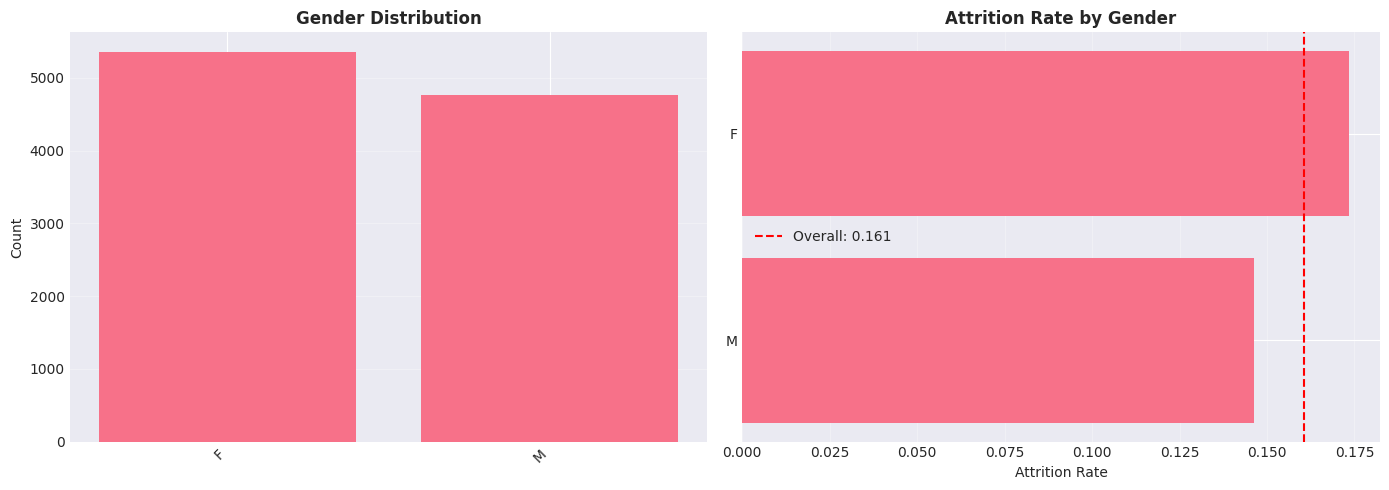


Gender별 이탈률:
        mean  count
Gender             
F      0.174   5358
M      0.146   4769


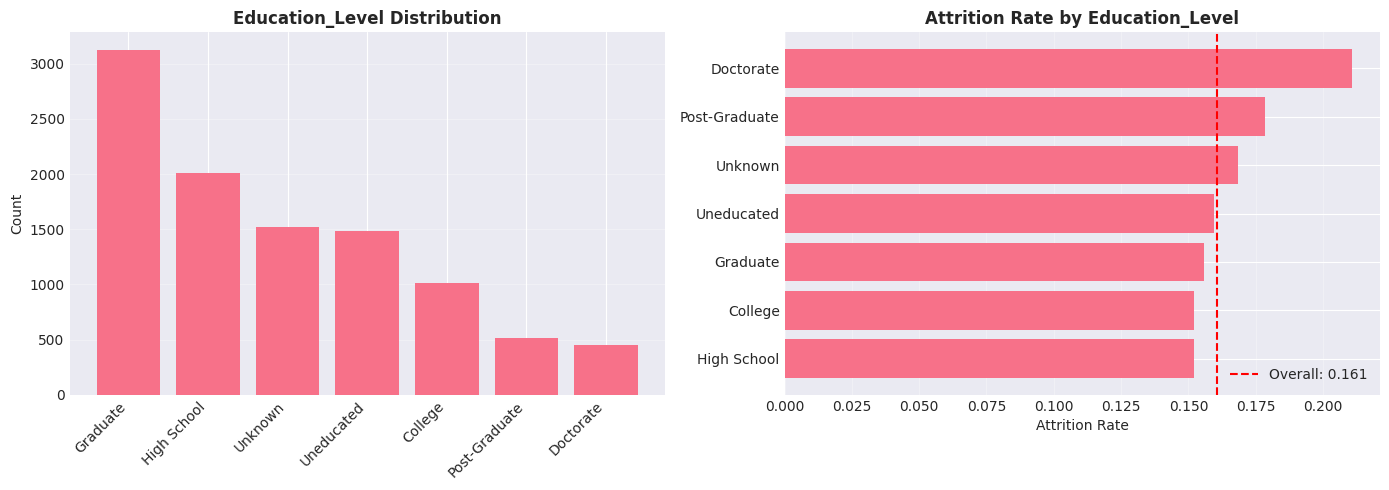


Education_Level별 이탈률:
                 mean  count
Education_Level             
Doctorate       0.211    451
Post-Graduate   0.178    516
Unknown         0.169   1519
Uneducated      0.159   1487
Graduate        0.156   3128
College         0.152   1013
High School     0.152   2013


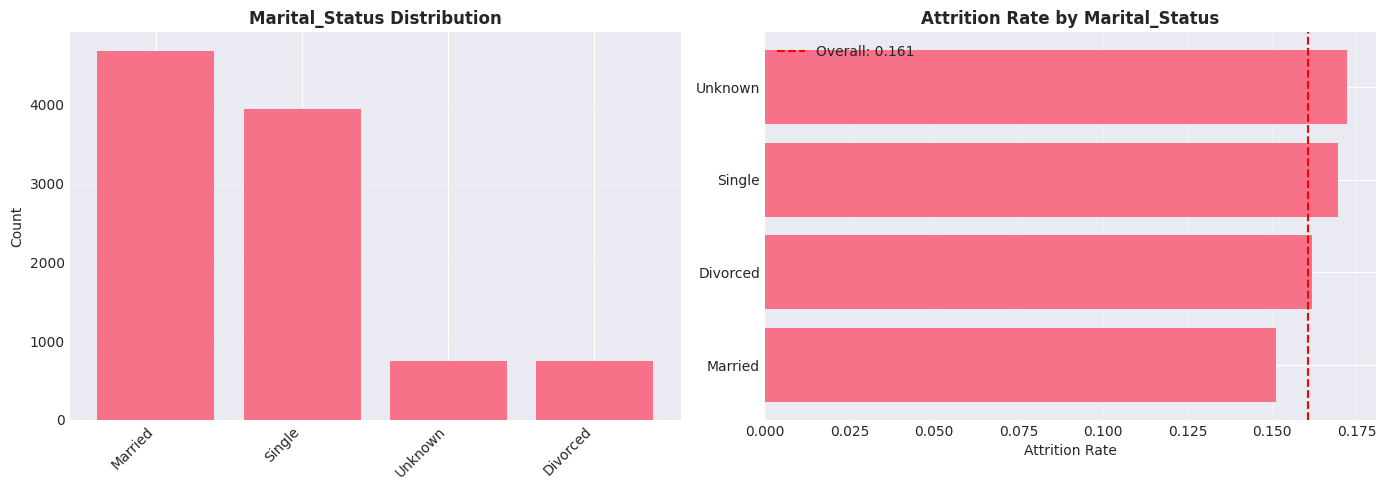


Marital_Status별 이탈률:
                mean  count
Marital_Status             
Unknown        0.172    749
Single         0.169   3943
Divorced       0.162    748
Married        0.151   4687


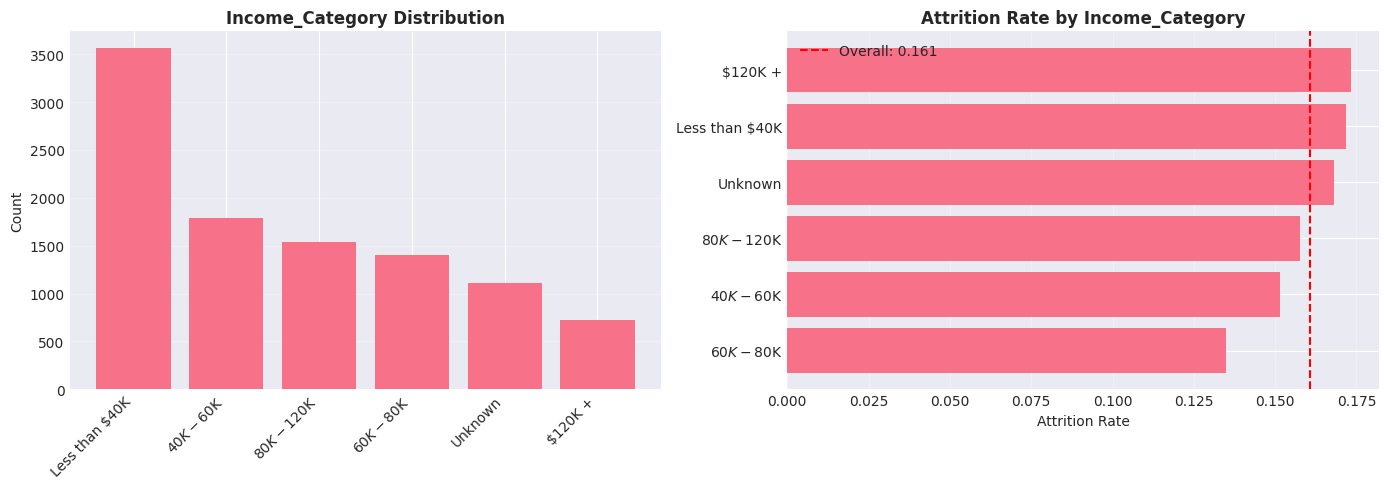


Income_Category별 이탈률:
                 mean  count
Income_Category             
$120K +         0.173    727
Less than $40K  0.172   3561
Unknown         0.168   1112
$80K - $120K    0.158   1535
$40K - $60K     0.151   1790
$60K - $80K     0.135   1402


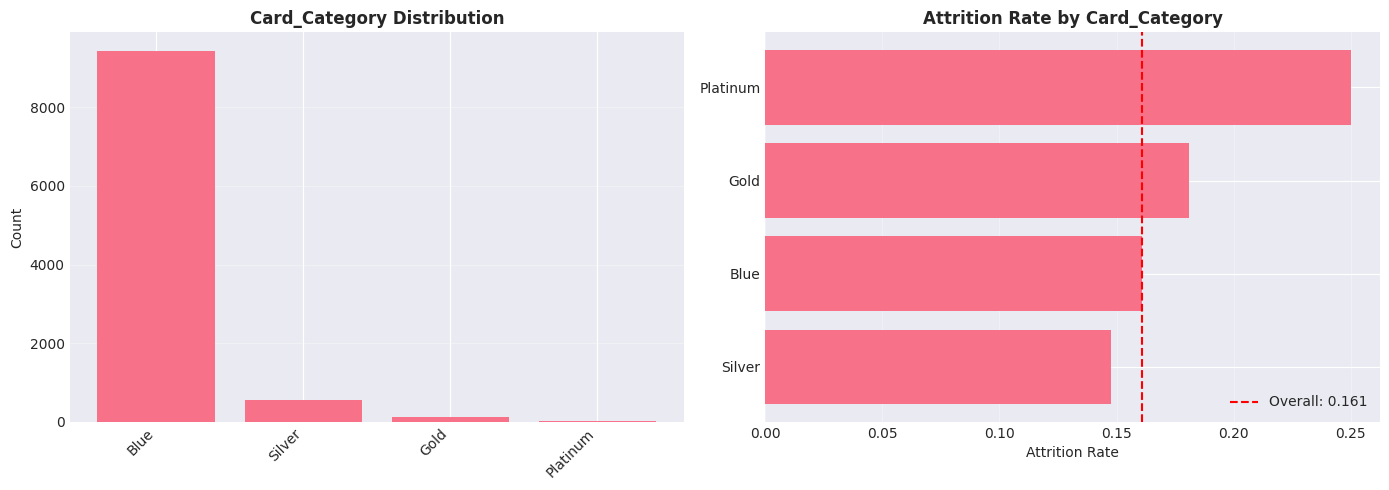


Card_Category별 이탈률:
               mean  count
Card_Category             
Platinum      0.250     20
Gold          0.181    116
Blue          0.161   9436
Silver        0.148    555


In [22]:
# 범주형 변수와 이탈률의 관계 분석
for col in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 전체 분포
    value_counts = df[col].value_counts()
    axes[0].bar(range(len(value_counts)), value_counts.values)
    axes[0].set_xticks(range(len(value_counts)))
    axes[0].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[0].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)
    
    # 각 카테고리별 이탈률
    attrition_rate = df.groupby(col)['Attrition_Binary'].mean().sort_values()
    axes[1].barh(range(len(attrition_rate)), attrition_rate.values)
    axes[1].set_yticks(range(len(attrition_rate)))
    axes[1].set_yticklabels(attrition_rate.index)
    axes[1].set_title(f'Attrition Rate by {col}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Attrition Rate')
    axes[1].grid(axis='x', alpha=0.3)
    
    # 평균 이탈률 선 추가
    overall_attrition = df['Attrition_Binary'].mean()
    axes[1].axvline(overall_attrition, color='red', linestyle='--', 
                    label=f'Overall: {overall_attrition:.3f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 수치로도 확인
    print(f"\n{col}별 이탈률:")
    print(df.groupby(col)['Attrition_Binary'].agg(['mean', 'count']).sort_values('mean', ascending=False))
    print("=" * 70)

## 6. 상관관계 분석

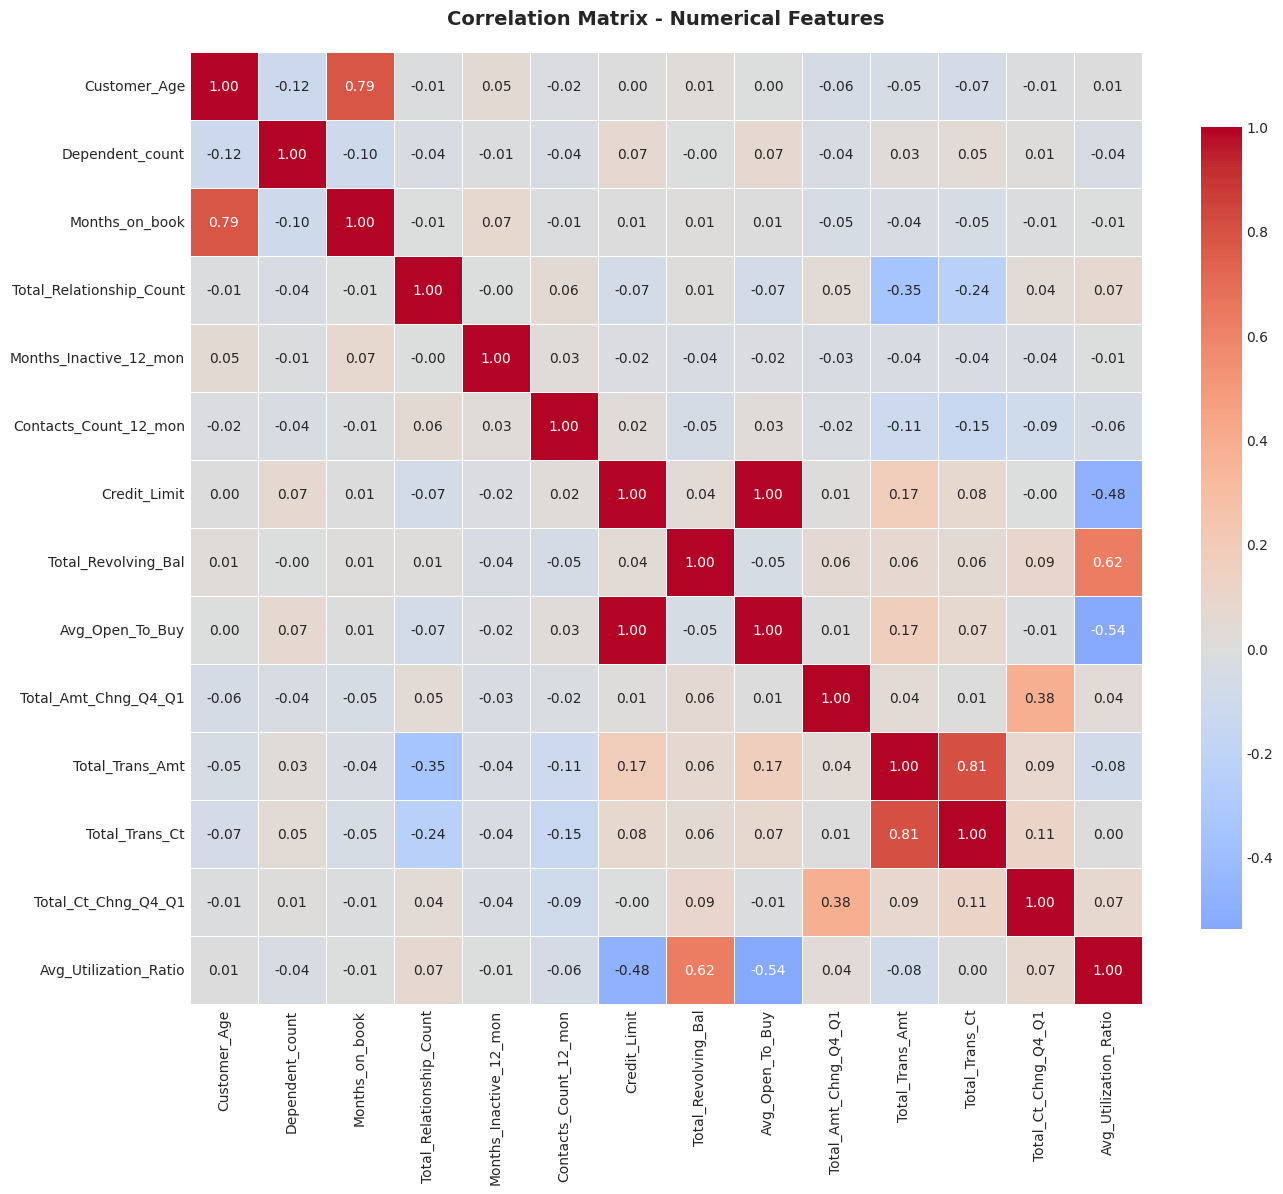

In [23]:
# 수치형 변수들 간의 상관관계
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [24]:
# 강한 상관관계 (다중공선성 가능성) 찾기
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:  # 임계값 0.7
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\n⚠️ 강한 상관관계를 가진 변수 쌍 (|r| > 0.7):")
    print("=" * 70)
    for col1, col2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{col1:30s} <-> {col2:30s} : {corr:6.3f}")
    print("\n→ 다중공선성 문제 가능성이 있으므로, Feature Selection 시 고려 필요")
else:
    print("\n✓ 강한 상관관계(|r| > 0.7)를 가진 변수 쌍이 없습니다.")


⚠️ 강한 상관관계를 가진 변수 쌍 (|r| > 0.7):
Credit_Limit                   <-> Avg_Open_To_Buy                :  0.996
Total_Trans_Amt                <-> Total_Trans_Ct                 :  0.807
Customer_Age                   <-> Months_on_book                 :  0.789

→ 다중공선성 문제 가능성이 있으므로, Feature Selection 시 고려 필요



Target(Attrition_Binary)와의 상관관계:
Total_Trans_Ct                     : -0.3714
Total_Ct_Chng_Q4_Q1                : -0.2901
Total_Revolving_Bal                : -0.2631
Contacts_Count_12_mon              :  0.2045
Avg_Utilization_Ratio              : -0.1784
Total_Trans_Amt                    : -0.1686
Months_Inactive_12_mon             :  0.1524
Total_Relationship_Count           : -0.1500
Total_Amt_Chng_Q4_Q1               : -0.1311
Credit_Limit                       : -0.0239
Dependent_count                    :  0.0190
Customer_Age                       :  0.0182
Months_on_book                     :  0.0137
Avg_Open_To_Buy                    : -0.0003


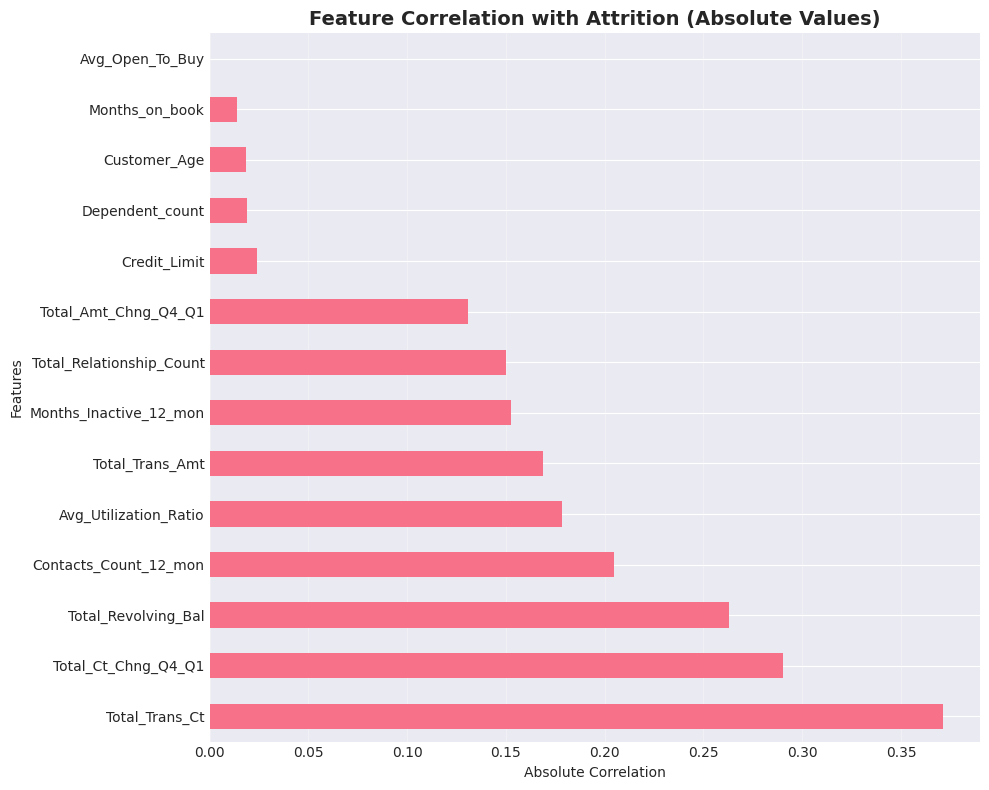


✨ Top 5 가장 강한 상관관계를 가진 변수:
1. Total_Trans_Ct                : -0.3714 (음의 상관)
2. Total_Ct_Chng_Q4_Q1           : -0.2901 (음의 상관)
3. Total_Revolving_Bal           : -0.2631 (음의 상관)
4. Contacts_Count_12_mon         :  0.2045 (양의 상관)
5. Avg_Utilization_Ratio         : -0.1784 (음의 상관)


In [25]:
# Target 변수(Attrition_Binary)와의 상관관계
target_correlation = df[numerical_cols + ['Attrition_Binary']].corr()['Attrition_Binary'].drop('Attrition_Binary')
target_correlation_sorted = target_correlation.abs().sort_values(ascending=False)

print("\nTarget(Attrition_Binary)와의 상관관계:")
print("=" * 50)
for col in target_correlation_sorted.index:
    corr_value = target_correlation[col]
    print(f"{col:35s}: {corr_value:7.4f}")

# 시각화
plt.figure(figsize=(10, 8))
target_correlation_sorted.plot(kind='barh')
plt.title('Feature Correlation with Attrition (Absolute Values)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Top 5 가장 중요한 변수
print("\n✨ Top 5 가장 강한 상관관계를 가진 변수:")
for i, (col, abs_corr) in enumerate(target_correlation_sorted.head(5).items(), 1):
    corr_value = target_correlation[col]
    direction = "양의 상관" if corr_value > 0 else "음의 상관"
    print(f"{i}. {col:30s}: {corr_value:7.4f} ({direction})")

## 7. Feature Engineering 아이디어

In [26]:
# 파생 변수 생성 예시
print("파생 변수 생성 중...\n")

# 1. 거래 빈도 (월평균 거래 횟수)
if 'Total_Trans_Ct' in df.columns and 'Months_on_book' in df.columns:
    df['Transaction_Frequency'] = df['Total_Trans_Ct'] / (df['Months_on_book'] + 1)  # +1로 0 방지
    print("✓ Transaction_Frequency 생성")

# 2. 평균 거래 금액
if 'Total_Trans_Amt' in df.columns and 'Total_Trans_Ct' in df.columns:
    df['Avg_Transaction_Amount'] = df['Total_Trans_Amt'] / (df['Total_Trans_Ct'] + 1)
    print("✓ Avg_Transaction_Amount 생성")

# 3. 신용 사용률 카테고리
if 'Avg_Utilization_Ratio' in df.columns:
    df['Utilization_Category'] = pd.cut(
        df['Avg_Utilization_Ratio'],
        bins=[-0.01, 0.3, 0.6, 1.01],
        labels=['Low', 'Medium', 'High']
    )
    print("✓ Utilization_Category 생성")

# 4. 고객 연령대
if 'Customer_Age' in df.columns:
    df['Age_Group'] = pd.cut(
        df['Customer_Age'],
        bins=[0, 30, 40, 50, 60, 100],
        labels=['20s', '30s', '40s', '50s', '60+']
    )
    print("✓ Age_Group 생성")

# 5. 고객 등급 (거래 기간 기준)
if 'Months_on_book' in df.columns:
    df['Customer_Tenure_Category'] = pd.cut(
        df['Months_on_book'],
        bins=[0, 12, 24, 36, 100],
        labels=['New(<1yr)', 'Regular(1-2yr)', 'Loyal(2-3yr)', 'VIP(3yr+)']
    )
    print("✓ Customer_Tenure_Category 생성")

# 6. 활동성 지표 (비활성 월수 비율)
if 'Months_Inactive_12_mon' in df.columns:
    df['Inactivity_Ratio'] = df['Months_Inactive_12_mon'] / 12
    print("✓ Inactivity_Ratio 생성")

print("\n파생 변수 생성 완료!")

파생 변수 생성 중...

✓ Transaction_Frequency 생성
✓ Avg_Transaction_Amount 생성
✓ Utilization_Category 생성
✓ Age_Group 생성
✓ Customer_Tenure_Category 생성
✓ Inactivity_Ratio 생성

파생 변수 생성 완료!


In [27]:
# 생성된 파생 변수와 이탈률의 관계 확인
derived_features = [
    'Transaction_Frequency',
    'Avg_Transaction_Amount',
    'Utilization_Category',
    'Age_Group',
    'Customer_Tenure_Category',
    'Inactivity_Ratio'
]

# 실제 생성된 컬럼만 필터링
derived_features = [col for col in derived_features if col in df.columns]

print("파생 변수와 이탈률의 관계:\n")
print("=" * 70)

for feature in derived_features:
    print(f"\n[{feature}]")
    
    if df[feature].dtype in ['object', 'category']:
        # 범주형 변수
        result = df.groupby(feature)['Attrition_Binary'].agg(['mean', 'count'])
        result.columns = ['Attrition_Rate', 'Count']
        print(result.sort_values('Attrition_Rate', ascending=False))
    else:
        # 수치형 변수
        corr = df[[feature, 'Attrition_Binary']].corr().iloc[0, 1]
        print(f"Correlation with Attrition: {corr:.4f}")
        print(df.groupby('Attrition_Flag')[feature].describe()[['mean', 'std', 'min', 'max']])
    
    print("-" * 70)

파생 변수와 이탈률의 관계:


[Transaction_Frequency]
Correlation with Attrition: -0.2924
                   mean   std   min   max
Attrition_Flag                           
Attrited Customer 1.284 0.590 0.185 6.357
Existing Customer 1.975 0.868 0.263 9.071
----------------------------------------------------------------------

[Avg_Transaction_Amount]
Correlation with Attrition: 0.0094
                    mean    std    min     max
Attrition_Flag                                
Attrited Customer 62.139 27.222 20.400 179.941
Existing Customer 61.466 26.054 18.814 188.056
----------------------------------------------------------------------

[Utilization_Category]
                      Attrition_Rate  Count
Utilization_Category                       
Low                            0.204   6253
High                           0.100   1802
Medium                         0.081   2072
----------------------------------------------------------------------

[Age_Group]
           Attrition_Rate  Count
Ag

In [29]:
# NaN 값 처리 후 Feature Engineering

df["Trans_Change_Ratio"] = (
    df["Total_Trans_Ct"] / (df["Total_Ct_Chng_Q4_Q1"] + 1)
)

df["Inactivity_Score"] = (
    df["Months_Inactive_12_mon"] * df["Avg_Utilization_Ratio"]
)

df["Engagement_Score"] = (
    df["Total_Trans_Amt"] * 0.4 +
    df["Total_Trans_Ct"] * 0.4 -
    df["Months_Inactive_12_mon"] * 0.2
)

# Avg_Utilization_Ratio의 NaN 값을 먼저 0으로 채우기
df["Utilization_Risk_Level"] = pd.cut(
    df["Avg_Utilization_Ratio"].fillna(0),  # NaN을 0으로 채우기
    bins=[0, 0.3, 0.6, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)

print("✓ Feature Engineering 완료!")
print(f"생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level")
print(f"최종 데이터 shape: {df.shape}")

✓ Feature Engineering 완료!
생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level
최종 데이터 shape: (10127, 34)


## 8. 주요 인사이트 정리

In [ ]:
print("="*70)
print("주요 EDA 인사이트 정리")
print("="*70)

print("\n1. 데이터 기본 정보")
print(f"   - 총 샘플 수: {len(df):,}개")
print(f"   - 전체 이탈률: {df['Attrition_Binary'].mean()*100:.2f}%")
print(f"   - 결측치: {'있음' if df.isnull().sum().sum() > 0 else '없음'}")

print("\n2. 가장 중요한 변수 (Top 5)")
if 'Attrition_Binary' in df.columns:
    top_features = target_correlation.abs().sort_values(ascending=False).head(5)
    for i, (feature, corr_abs) in enumerate(top_features.items(), 1):
        corr_value = target_correlation[feature]
        print(f"   {i}. {feature}: {corr_value:.4f}")

print("\n3. 주의사항")
if high_corr_pairs:
    print(f"   - 다중공선성 가능성: {len(high_corr_pairs)}개 변수 쌍")
if minority_class_ratio < 0.3:
    print(f"   - 클래스 불균형 문제 존재 (비율: {minority_class_ratio:.3f})")

print("\n4. 다음 단계 추천")
print("   - Feature Selection (상관관계 높은 변수 선택)")
print("   - Feature Engineering (파생 변수 추가 생성)")
print("   - 데이터 전처리 (스케일링, 인코딩)")
if minority_class_ratio < 0.3:
    print("   - 클래스 불균형 처리 (SMOTE, class_weight 등)")
print("   - 모델 학습 (Stratified K-Fold CV 사용)")

print("\n" + "="*70)

주요 EDA 인사이트 정리

1. 데이터 기본 정보
   - 총 샘플 수: 10,127개
   - 전체 이탈률: 16.07%
   - 결측치: 없음

2. 가장 중요한 변수 (Top 5)
   1. Total_Trans_Ct: -0.3714
   2. Total_Ct_Chng_Q4_Q1: -0.2901
   3. Total_Revolving_Bal: -0.2631
   4. Contacts_Count_12_mon: 0.2045
   5. Avg_Utilization_Ratio: -0.1784

3. 주의사항
   - 다중공선성 가능성: 3개 변수 쌍
   - 클래스 불균형 문제 존재 (비율: 0.191)

4. 다음 단계 추천
   - Feature Selection (상관관계 높은 변수 선택)
   - Feature Engineering (파생 변수 추가 생성)
   - 데이터 전처리 (스케일링, 인코딩)
   - 클래스 불균형 처리 (SMOTE, class_weight 등)
   - 모델 학습 (Stratified K-Fold CV 사용)



## 추가 분석 (선택사항)

In [ ]:
# Naive Bayes 컬럼 확인 (있다면 제거 필요)
nb_cols = [col for col in df.columns if 'Naive_Bayes' in col]

if nb_cols:
    print("⚠️ 주의: Naive Bayes 예측 컬럼 발견!")
    print(f"발견된 컬럼: {nb_cols}")
    print("\n이 컬럼은 이미 예측값이므로 모델 학습 시 제외해야 합니다.")
    print("(Data Leakage 문제)")
else:
    print("✓ Naive Bayes 예측 컬럼 없음")

⚠️ 주의: Naive Bayes 예측 컬럼 발견!
발견된 컬럼: ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

이 컬럼은 이미 예측값이므로 모델 학습 시 제외해야 합니다.
(Data Leakage 문제)


In [ ]:
# 최종 데이터 저장 (선택사항)
# 파생 변수가 추가된 데이터를 저장하고 싶다면 주석 해제
# df.to_csv('credit_card_churn_with_features.csv', index=False)
# print("✓ 데이터 저장 완료: credit_card_churn_with_features.csv")

## 다음 단계: 모델링을 위한 데이터 준비

EDA가 완료되었습니다! 다음 단계는:

1. **Feature Selection**: 중요한 변수 선택
2. **Data Preprocessing**:
   - 범주형 변수 인코딩 (One-Hot Encoding, Label Encoding)
   - 수치형 변수 스케일링 (StandardScaler, MinMaxScaler)
   - Train/Test Split (Stratified)
3. **Modeling**:
   - Baseline 모델 (Logistic Regression)
   - Tree-based 모델 (LightGBM, XGBoost, Random Forest)
   - Stratified K-Fold CV로 평가
4. **Hyperparameter Tuning**: Optuna, GridSearch 등
5. **Model Evaluation**: AUC, F1-Score, Recall 등

궁금한 점이 있으면 언제든 물어보세요! 🚀